In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg", 40

try: # Skip loading if already loaded
    aggregator_o
except:
    aggregator_o, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_o, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator_o, args_)[0]


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 165.26it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:09<00:00,  4.00it/s]


In [9]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 30
setting = 'FedAvg_adv'
num_users = [1,3,5,10]


test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 15


save_path_FAT150 = 'weights/cifar10/231031_FAT150round/FAT/'


for num_user in num_users:
    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    aggregator, clients, args_ = set_args(setting, 40)

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FAT150)
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    aggregator.update_clients()
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()
    
    for c in aggregator.clients:
        c.unlearning_flag = True
    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_o, model_FAT)

    prev_model = copy.deepcopy(model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
     # Assign proportion and attack params
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%5 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_o, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 234.39it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


round 0 Test acc:  0.7984375119209289 ( 0.06472221216006704 ) adv acc:  0.3462500084191561 ( 0.07219764475759717 )
round 5 Test acc:  0.48968751206994054 ( 0.10337611878482343 ) adv acc:  0.13843750120140613 ( 0.062835816785229 )
round 10 Test acc:  0.5034375108778477 ( 0.10322864665808754 ) adv acc:  0.1375000023515895 ( 0.052885489862072796 )
round 15 Test acc:  0.5137500114738941 ( 0.09729947770496944 ) adv acc:  0.14906250345520675 ( 0.05648475382751919 )
round 20 Test acc:  0.5309375129640103 ( 0.101357490801125 ) adv acc:  0.14562500370666384 ( 0.05358623371496549 )
round 25 Test acc:  0.5334375083446503 ( 0.10156538514661 ) adv acc:  0.1525000024586916 ( 0.04594494096629778 )
round 30 Test acc:  0.537500011920929 ( 0.10000000577420118 ) adv acc:  0.1500000032130629 ( 0.057486411676795676 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 236.02it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.54it/s]


round 0 Test acc:  0.8006250113248825 ( 0.06672881190679483 ) adv acc:  0.33343750331550837 ( 0.08428872729167858 )
round 5 Test acc:  0.5590625114738941 ( 0.06578774970485886 ) adv acc:  0.06562500114087015 ( 0.029679275699615544 )
round 10 Test acc:  0.6121875122189522 ( 0.0805977433879069 ) adv acc:  0.07781250183470548 ( 0.03324712259323443 )
round 15 Test acc:  0.633437505364418 ( 0.08924104767041291 ) adv acc:  0.08781250100582838 ( 0.03217232700297459 )
round 20 Test acc:  0.6381250128149987 ( 0.0757230767928875 ) adv acc:  0.08093750141561032 ( 0.03718487441662431 )
round 25 Test acc:  0.6418750174343586 ( 0.07952741514026095 ) adv acc:  0.08875000136904418 ( 0.030973779693075767 )
round 30 Test acc:  0.6253125131130218 ( 0.0759567867862694 ) adv acc:  0.08031250131316484 ( 0.03675164825755195 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 234.44it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


round 0 Test acc:  0.8087500110268593 ( 0.0606733008987623 ) adv acc:  0.34625000655651095 ( 0.07792224068304432 )
round 5 Test acc:  0.6143750086426735 ( 0.0604378623001094 ) adv acc:  0.07906250106170773 ( 0.02410710215349776 )
round 10 Test acc:  0.6815625160932541 ( 0.06379823978713055 ) adv acc:  0.08750000125728548 ( 0.03162277745944438 )
round 15 Test acc:  0.6746875122189522 ( 0.0725370322096406 ) adv acc:  0.0956250018440187 ( 0.027178519596489217 )
round 20 Test acc:  0.6896875157952309 ( 0.0718009136673066 ) adv acc:  0.09906250201165676 ( 0.030154226849348306 )
round 25 Test acc:  0.6903125122189522 ( 0.06492107529583975 ) adv acc:  0.09812500132247806 ( 0.03541605514333416 )
round 30 Test acc:  0.684375011920929 ( 0.07069686651192496 ) adv acc:  0.0887500011594966 ( 0.03269174289042187 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 233.86it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


round 0 Test acc:  0.8050000131130218 ( 0.0648194580191936 ) adv acc:  0.34468750692903993 ( 0.08027722955742032 )
round 5 Test acc:  0.6978125095367431 ( 0.07483771393393361 ) adv acc:  0.10125000150874257 ( 0.03488821446184001 )
round 10 Test acc:  0.7218750134110451 ( 0.0675896392367898 ) adv acc:  0.0971875015180558 ( 0.033713812289272636 )
round 15 Test acc:  0.7287500098347663 ( 0.06520400375639909 ) adv acc:  0.10406250155065208 ( 0.03028349243655827 )
round 20 Test acc:  0.713750010728836 ( 0.07540515553083098 ) adv acc:  0.10218750203493983 ( 0.03901997795948204 )
round 25 Test acc:  0.7193750143051147 ( 0.06174228441630931 ) adv acc:  0.10281250216066837 ( 0.03775822643547537 )
round 30 Test acc:  0.7284375101327896 ( 0.07048867282616218 ) adv acc:  0.10000000153668225 ( 0.033888605591574764 )


In [10]:
dict_list = [test_acc_gather, adv_acc_gather, test_acc_std_gather, adv_acc_std_gather]

# Directory where you want to save the pickle file
directory = 'saved_results/240813_arue_std/'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Path to the pickle file
file_path = os.path.join(directory, 'acc_std_gather_list_perturb_05_v3.pkl')
# Pickle the dictionary and save it to the file
with open(file_path, 'wb') as file:
    pickle.dump(dict_list, file)

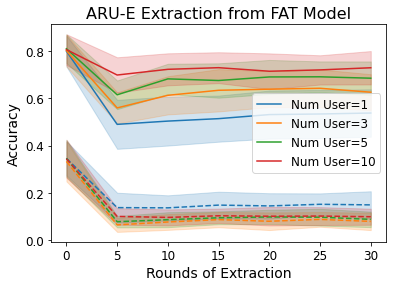

In [18]:

# Initialize a new figure
plt.figure(figsize=(6, 4))

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 35, 5)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('ARU-E Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()